<a href="https://colab.research.google.com/github/Fcazarez/NN-DL_Ass4_Word_Embeddings_for_Shakespearean/blob/main/Copy_of_NN%26DL_Ass4_Word_Embeddings_for_Shakespearean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP-3704 (241552) Neural Networks and Deep Learning**
# **Assignment 4: Word Embeddings for Shakespearean English**
## **Group 3 - Francisco, Felix, Elizer**






## **Instructions**
## **Objective:**
  - To train word embeddings on famous works of Shakespeare and evaluate their understanding.



## **Data:**
  - The entire text of plays:
    1) The Tragedy of Hamlet, Prince of Denmark
    2) The Tragedy of Macbeth
    3) The Tragedy of Julius Caesar.
  - These are available from the Gutenberg corpus of the NLTK library. Characters and synopses can be found on Wikipedia.



## **Problem Statement:**
* Natural language processing is an important part of the most advanced artificial intelligence software we have today. By studying volumes of text, word embeddings are able to elicit meaning from the words within training data. Your goal is to train a word embedding on three famous works of Shakespeare to determine how well your embedding can understand the meaning of character names and other Shakespearean English words found in these plays.



In [ ]:
#libraries
import numpy as np
import pandas as pd
import nltk
import os
from nltk import tokenize
import gensim.downloader as api
from string import punctuation
from gensim.models import word2vec
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.cm as cm

**Comments:**
The purpose of the next lines of code are to visualize the relationships between words in a word embeddings model by projecting them into a 2D space and plotting them with labels. This can be helpful for understanding how words are semantically related and how they cluster in the reduced space.

In [ ]:
# based on: https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
## models visualization:
def create_embeddings(model,  keys):

  embedding_clusters = []
  word_clusters = []
  for word in keys:
      embeddings = []
      words = []

      for similar_word, _ in model.most_similar(word, topn=10):
          words.append(similar_word)
          embeddings.append(model[similar_word])
      embedding_clusters.append(embeddings)
      word_clusters.append(words)

  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

  return (embeddings_en_2d, word_clusters)

def tsne_plot_similar_words(title, model, labels, a):
    keys = []
    for _word in labels:
      if _word in model.key_to_index:
        keys.append(_word)

    embedding_clusters, word_clusters = create_embeddings(model, keys)

    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(keys)))
    for label, embeddings, words, color in zip(keys, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)

    plt.show()

    #tsne_plot_similar_words('Similar words', keys, embeddings_en_2d, word_clusters, 0.7,
    #                    'similar_words.png')

# 1. **Data Part a)**
* Use nltk.corpus.gutenberg.raw to load the three plays listed above into a single variable and lower the case.

In [ ]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [ ]:
# get the texts
hamlet_txt = nltk.corpus.gutenberg.raw('shakespeare-hamlet.txt')
macbeth_txt = nltk.corpus.gutenberg.raw('shakespeare-macbeth.txt')
julius_caesar_txt = nltk.corpus.gutenberg.raw('shakespeare-caesar.txt')

In [ ]:
shakespeare_txt = hamlet_txt + macbeth_txt + julius_caesar_txt

# 1. **Data Part b)**
 * Perform the following steps in an order of your choosing:
 * Tokenize the text into sentences, and then each sentence into words.
 * Use Speller from the autocorrect library to correct spelling mistakes.
 * Create a list of stopwords (using publicly available lists and/or adding your own) and remove these.
 * Use PorterStemmer or WordNetLemmatizer from nltk.stem on the text.
 * Use regular expressions (the re library) to do any additional cleanup of the text you wish to do.



In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#The sent_tokenize() method breaks input text into constituent sentences
tokenize.sent_tokenize(shakespeare_txt)

['[The Tragedie of Hamlet by William Shakespeare 1599]\n\n\nActus Primus.',
 'Scoena Prima.',
 'Enter Barnardo and Francisco two Centinels.',
 'Barnardo.',
 "Who's there?",
 'Fran.',
 'Nay answer me: Stand & vnfold\nyour selfe\n\n   Bar.',
 'Long liue the King\n\n   Fran.',
 'Barnardo?',
 'Bar.',
 'He\n\n   Fran.',
 'You come most carefully vpon your houre\n\n   Bar.',
 "'Tis now strook twelue, get thee to bed Francisco\n\n   Fran.",
 "For this releefe much thankes: 'Tis bitter cold,\nAnd I am sicke at heart\n\n   Barn.",
 'Haue you had quiet Guard?',
 'Fran.',
 'Not a Mouse stirring\n\n   Barn.',
 'Well, goodnight.',
 'If you do meet Horatio and\nMarcellus, the Riuals of my Watch, bid them make hast.',
 'Enter Horatio and Marcellus.',
 'Fran.',
 'I thinke I heare them.',
 "Stand: who's there?",
 'Hor.',
 'Friends to this ground\n\n   Mar.',
 'And Leige-men to the Dane\n\n   Fran.',
 'Giue you good night\n\n   Mar.',
 "O farwel honest Soldier, who hath relieu'd you?",
 'Fra.',
 "Barnar

In [ ]:
# assign the result to a variable for ease of handling
txt_sents = tokenize.sent_tokenize(shakespeare_txt)
type(txt_sents), len(txt_sents)

(list, 5412)

### *CASE NORMALIZATION, PUNCTUATION AND STOPWORD REMOVAL*

In [ ]:
# normalize the case of our data using the lower() method after tokenizing into individual sentences.
txt_sents = [sent.lower() for sent in txt_sents]
txt_words = [tokenize.word_tokenize(sent) for sent in txt_sents]

In [ ]:
print(txt_words[:2])

[['[', 'the', 'tragedie', 'of', 'hamlet', 'by', 'william', 'shakespeare', '1599', ']', 'actus', 'primus', '.'], ['scoena', 'prima', '.']]


In [ ]:
# Using list in the string base library in Python,
list_punct = list(punctuation)
print(list_punct)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [ ]:
# drop the tokens that are available in the list_punct variable:
def drop_punct(input_tokens):
    return [token for token in input_tokens \
        if token not in list_punct]

In [ ]:
# Functional stop words that are built into NLTK.
nltk.download("stopwords")
list_stop = stopwords.words("english")
len(list_stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [ ]:
print(list_stop[:50])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be']


In [ ]:
# Import punctuation from the string module and convert it into a list:
stop_punct = list(punctuation)

In [ ]:
# Import the built-in stop words for English from NLTK and save them in a variable:
stop_nltk = stopwords.words("english")

In [ ]:
# Create a combined list that contains the punctuations as well as the NLTK stop words.
# Note that we can remove them together in one go:
# ['s, 'd] added based on prior execution of word2vec
stop_final = stop_punct + stop_nltk + ["'s", "'d", "vp", "vs", "thou", "'t", "'re", "is't", 'well', "thou", "thee", "thy", "thine", "ye", "art", "hath", "dost", "shalt", "wilt",
    "hast", "doth", "hast", "n't"]

In [ ]:
# Define a function that will remove stop words and punctuation from the input sentence,
def drop_stop(input_tokens):
    return [token for token in input_tokens \
        if token not in stop_final]

In [ ]:
# Remove redundant tokens by applying the function to the tokenized sentences and store the result in a variable:
txt_words_nostop = [drop_stop(sent) for sent in txt_words]
txt_words_nostop

[['tragedie', 'hamlet', 'william', 'shakespeare', '1599', 'actus', 'primus'],
 ['scoena', 'prima'],
 ['enter', 'barnardo', 'francisco', 'two', 'centinels'],
 ['barnardo'],
 [],
 ['fran'],
 ['nay', 'answer', 'stand', 'vnfold', 'selfe', 'bar'],
 ['long', 'liue', 'king', 'fran'],
 ['barnardo'],
 ['bar'],
 ['fran'],
 ['come', 'carefully', 'vpon', 'houre', 'bar'],
 ['strook', 'twelue', 'get', 'bed', 'francisco', 'fran'],
 ['releefe', 'much', 'thankes', 'bitter', 'cold', 'sicke', 'heart', 'barn'],
 ['haue', 'quiet', 'guard'],
 ['fran'],
 ['mouse', 'stirring', 'barn'],
 ['goodnight'],
 ['meet', 'horatio', 'marcellus', 'riuals', 'watch', 'bid', 'make'],
 ['enter', 'horatio', 'marcellus'],
 ['fran'],
 ['thinke', 'heare'],
 ['stand'],
 ['hor'],
 ['friends', 'ground', 'mar'],
 ['leige-men', 'dane', 'fran'],
 ['giue', 'good', 'night', 'mar'],
 ['farwel', 'honest', 'soldier', 'relieu'],
 ['fra'],
 ['barnardo', 'ha', 'place', 'giue', 'goodnight'],
 ['exit', 'fran'],
 ['mar'],
 ['holla', 'barnardo', 

### *STEMMING*

In [ ]:
# stemming with a list of words to be ignored, for example, army is transformed into armi.
words_to_not_modify = ["army"]
stemmer_p = PorterStemmer()
txt_words_stem =[]
for sent in txt_words_nostop:
    local_words = []
    for token in sent:
        if token in words_to_not_modify:
            local_words.append(token)
        else:
            local_words.append(stemmer_p.stem(token))
    txt_words_stem.append(local_words)

In [ ]:
# Print the first cleaned-up sentence from the data:
print(txt_words_stem[0])

['tragedi', 'hamlet', 'william', 'shakespear', '1599', 'actu', 'primu']


### * Use regular expressions (the re library) to do any additional cleanup of the text you wish to do.

**Removing numbers with REGEX**

In [ ]:
import re
# Remove numbers using regular expression
for i in range(len(txt_words_stem)):
  words = txt_words_stem[i]
  for j in range(len(words)):
    w = words[j]
    cleaned_text = re.sub(r'\d+', '', w)
    txt_words_stem[i][j] = cleaned_text

# 1. **Data Part c)**
* Print out the words in the first five sentences of the processed text data. (Viewing this may give you additional ideas for the previous steps.)



In [ ]:
# Print the first three cleaned-up sentences from the data:
for i in range(5):
    print(txt_words_stem[i])

['tragedi', 'hamlet', 'william', 'shakespear', '', 'actu', 'primu']
['scoena', 'prima']
['enter', 'barnardo', 'francisco', 'two', 'centinel']
['barnardo']
[]


# 2. **Modeling Part a)**

* Create a CBOW word2vec model from gensim.model. Make choices of vector_size, epochs, window, min_count, and possibly other hyperparameters.
* Train it on the cleaned Shakespeare text data.
* Use gensim.model.wv.key_to_index and gensim.model.wv.get_vecattr to print out a list of the 20 most frequent words in the vocabulary along with the word count. Consider improving the text cleaning steps above based on this information.



In [ ]:
# test 5 different cases
# params description:

# vector_size: Dimensionality of the word vectors.
# window: Maximum distance between the current and predicted word within a sentence.
# min_count: Ignores all words with total frequency lower than this.
# sg: Training algorithm: 1 for skip-gram; otherwise CBOW.
# epochs: Number of iterations (epochs) over the corpus. (Formerly: iter)

def train_word2vec(dataset, _sg=0):
  # Lists of hyperparameters to experiment with
  vector_sizes = [200 ,300, 300, 400, 500]
  epochs = [5,10,15,20,20]
  windows = [50,100,150,200,250]
  min_counts = [3,2,3,1,2]
  # Initialize an empty list to store trained Word2Vec models
  models = []
  # Iterate through different hyperparameter combinations
  for i in range(len(vector_sizes)):
    _v_size = vector_sizes[i]
    _epochs = epochs[i]
    _window = windows[i]
    _min_count = min_counts[i]
    # Train a Word2Vec model with the current hyperparameters
    model = word2vec.Word2Vec(dataset
                            , vector_size =_v_size
                            , window=_window
                            , epochs=_epochs
                            , min_count=_min_count
                            , sg=0)                  # Set to 0 for CBOW, 1 for skip-gram
    # Append the trained model to the list of models
    models.append(model)
  # Return the list of trained Word2Vec models
  return models

# Essentially, the vocabulary is a list (accessible via model.wv.index_to_key) of all of the unique words extracted from the training corpus.
# Additional attributes for each word are available using the model.wv.get_vecattr() method, For example, to see how many times penalty appeared in the training corpus:

# Define a function to show the most common words and their counts.
def show_common_word(wv, word_count=20):
  # Get the list of most common words in the vocabulary
  most_common_words = list(wv.key_to_index)[:word_count + 1]

  counts = []
  # Extract word counts for the most common words
  for w in most_common_words:
    counts.append(w + ":" + str(wv.get_vecattr(w, 'count')))
  # Print the list of common words and their counts
  print(counts)

def plot_model(wv, keys, word_count=20):
    if keys == [] or keys == None:
      keys = list(wv.key_to_index)[:word_count + 1]
    tsne_plot_similar_words('Similar words', wv, keys, 1)

In [ ]:
# use the `train_word2vec` function to train Word2Vec models with different configurations.
# Train a CBOW model:
models = train_word2vec(txt_words_stem)
for m in models:
    show_common_word(m.wv, 20)

['haue:444', 'ham:337', 'lord:306', 'shall:300', 'come:284', 'king:248', 'enter:232', 'caesar:231', 'let:221', 'good:216', 'know:186', 'brutu:162', 'like:162', 'would:159', 'vpon:157', 'bru:153', 'make:152', 'say:146', 'man:145', 'speak:144', 'one:144']
['haue:444', 'ham:337', 'lord:306', 'shall:300', 'come:284', 'king:248', 'enter:232', 'caesar:231', 'let:221', 'good:216', 'know:186', 'like:162', 'brutu:162', 'would:159', 'vpon:157', 'bru:153', 'make:152', 'say:146', 'man:145', 'one:144', 'speak:144']
['haue:444', 'ham:337', 'lord:306', 'shall:300', 'come:284', 'king:248', 'enter:232', 'caesar:231', 'let:221', 'good:216', 'know:186', 'brutu:162', 'like:162', 'would:159', 'vpon:157', 'bru:153', 'make:152', 'say:146', 'man:145', 'speak:144', 'one:144']
['haue:444', 'ham:337', 'lord:306', 'shall:300', 'come:284', 'king:248', 'enter:232', 'caesar:231', 'let:221', 'good:216', 'know:186', 'brutu:162', 'like:162', 'would:159', 'vpon:157', 'bru:153', 'make:152', 'say:146', 'man:145', 'speak:1

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


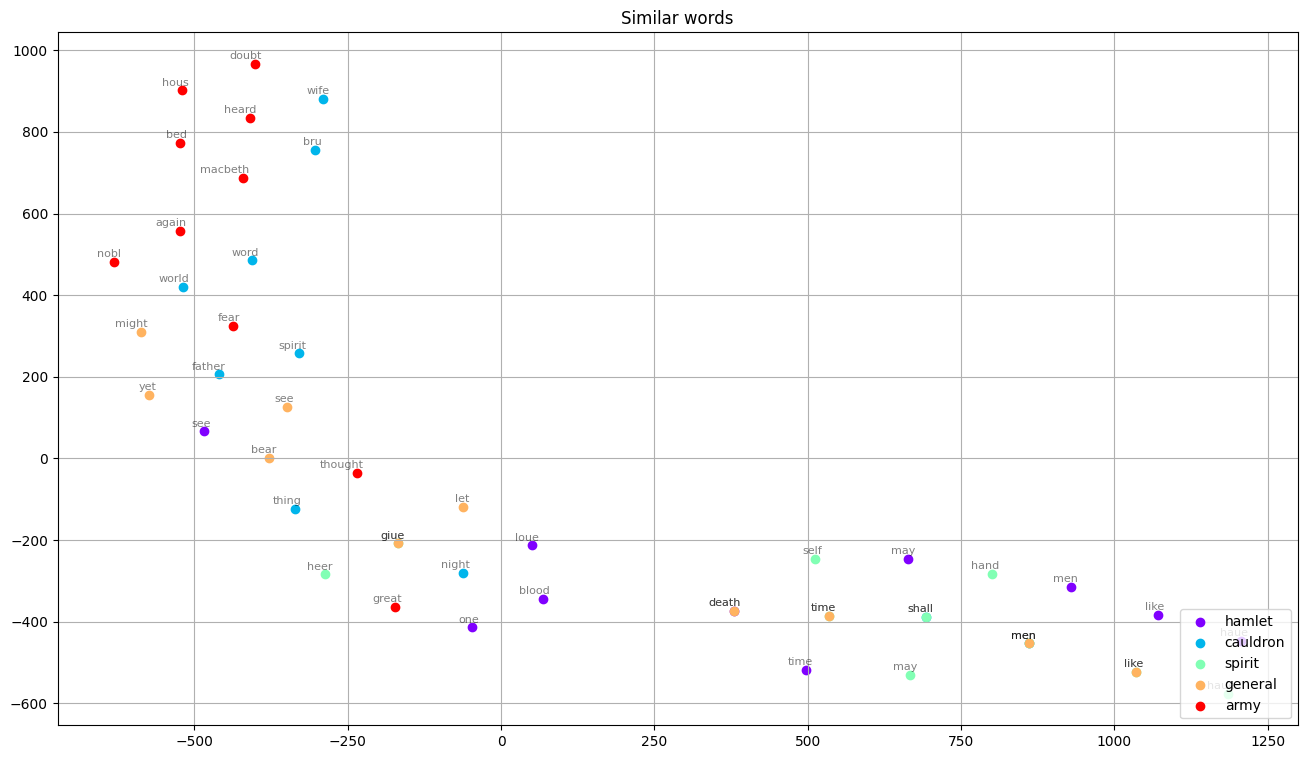

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


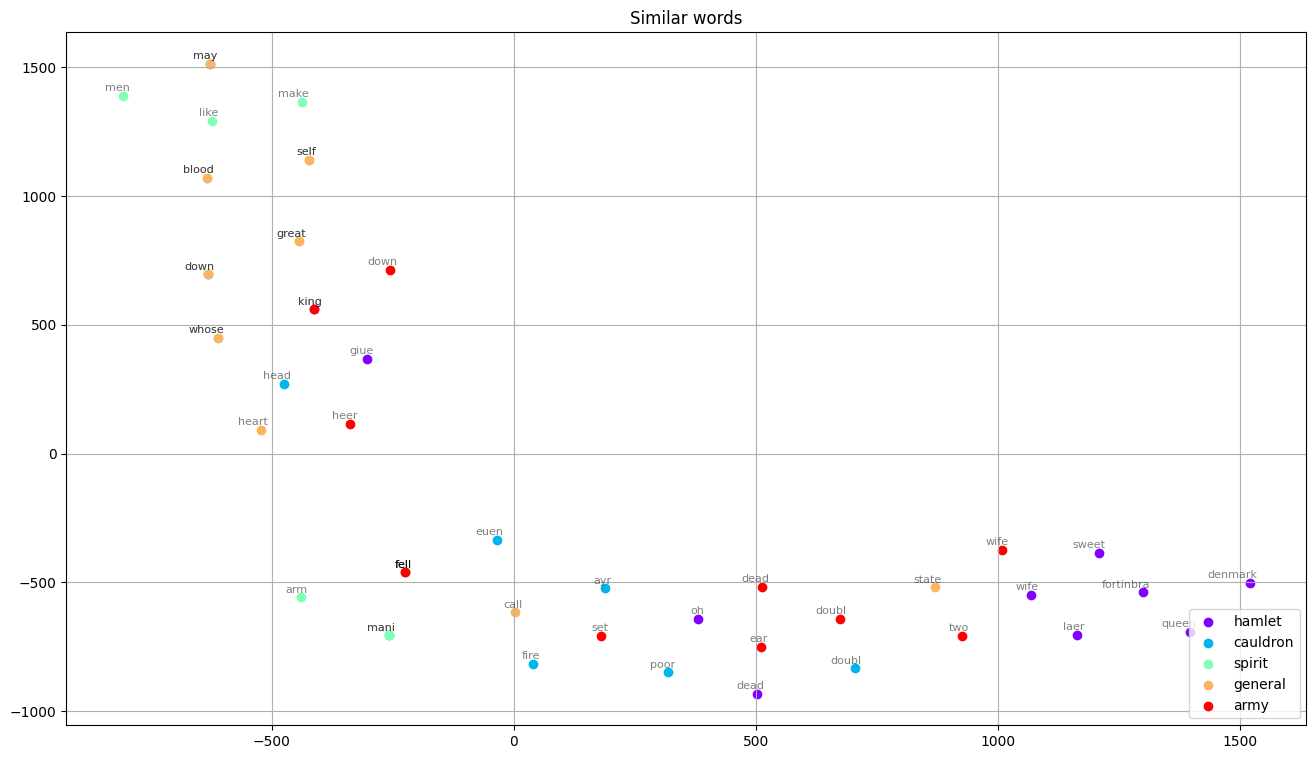

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


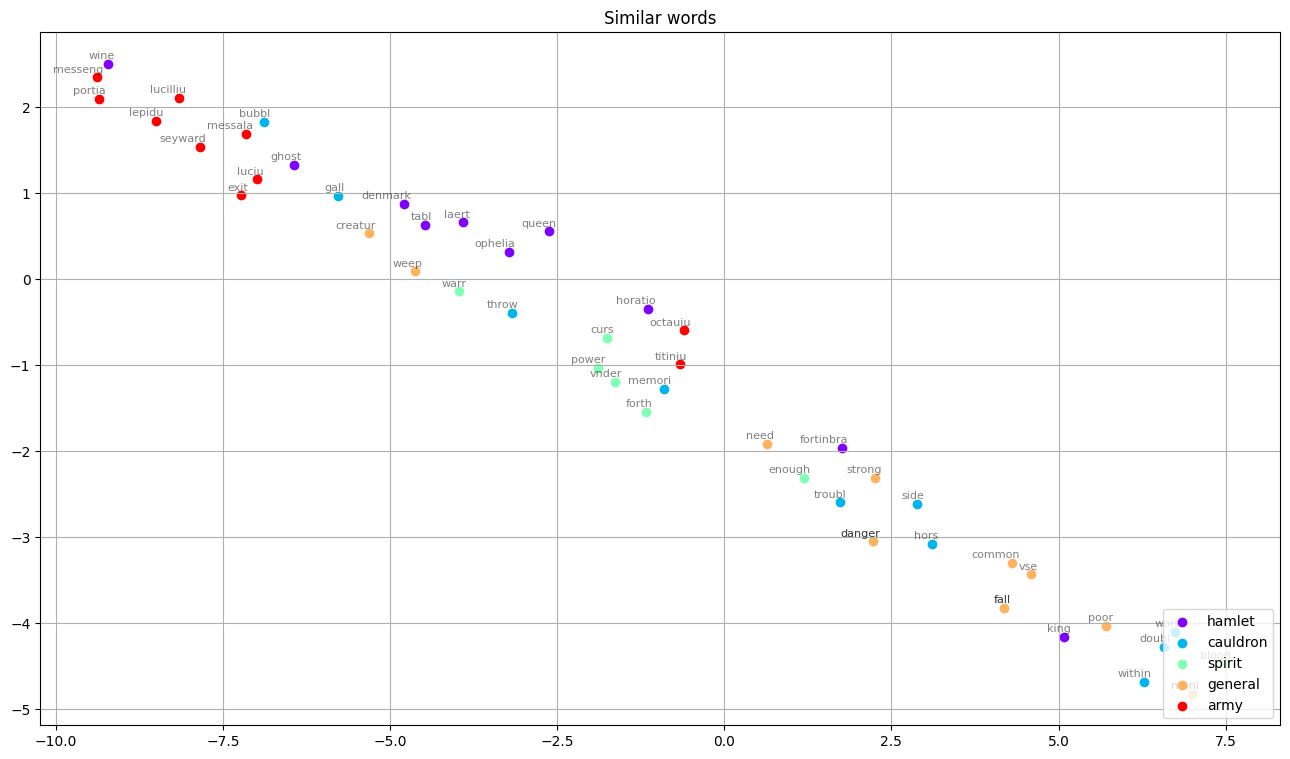

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


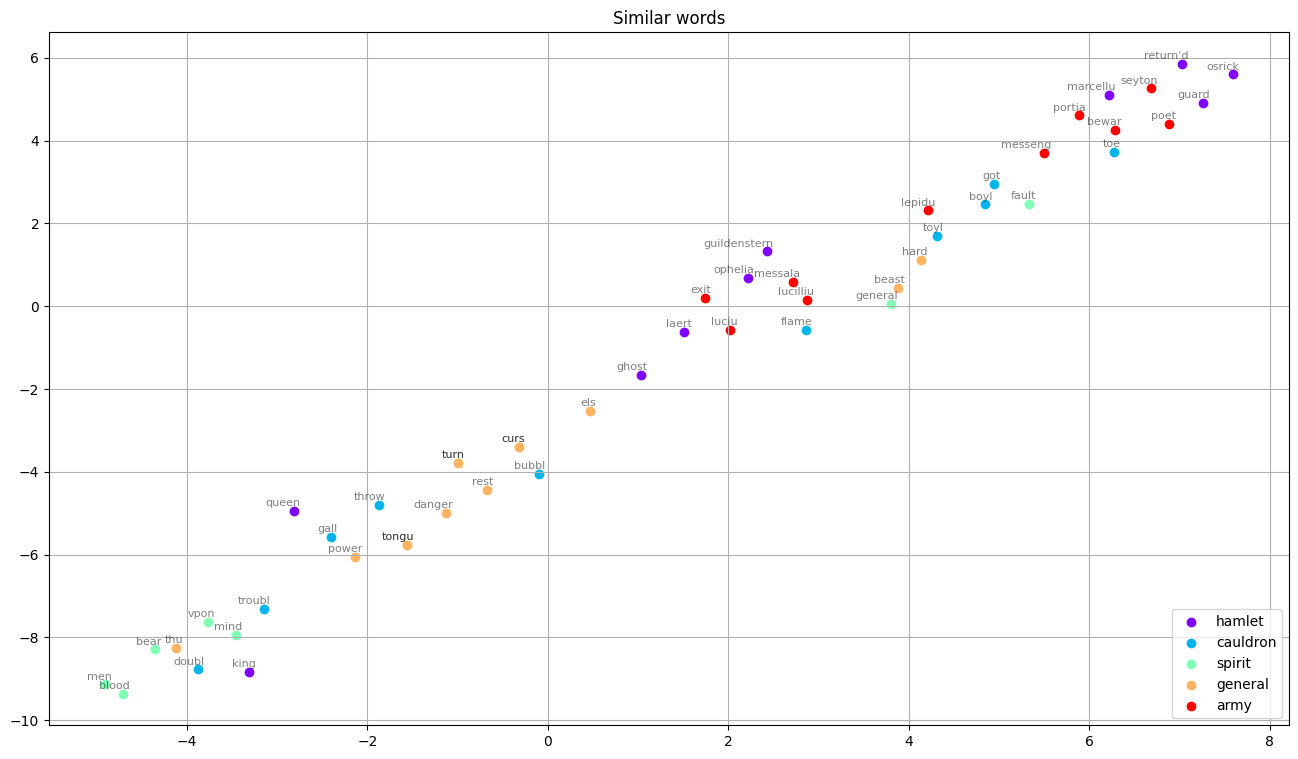

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


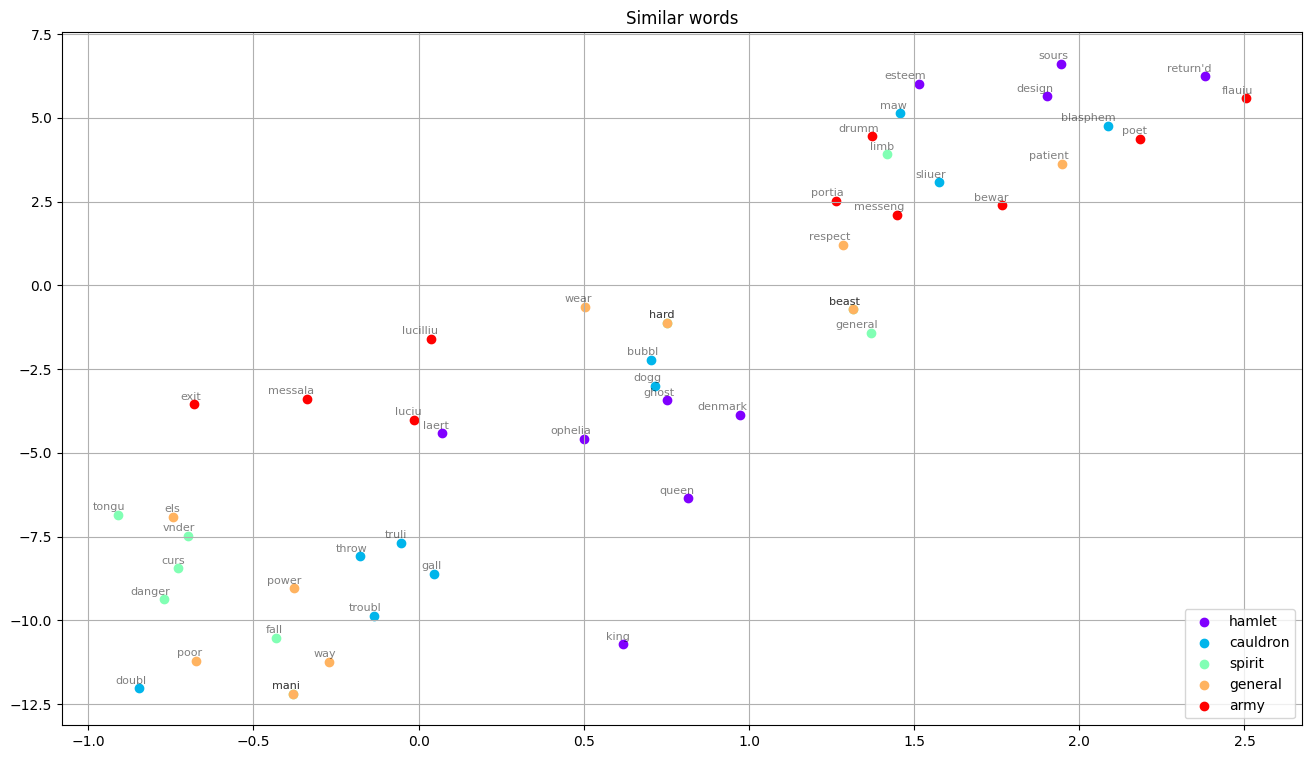

In [ ]:
part_b_words = ['hamlet', 'cauldron', 'nature', 'spirit', 'general',  'prythee', "army"]

for m in models:
    plot_model(m.wv,part_b_words, 10)

# 2. **Modeling Part b)**
* Create a skipgram word2vec model from gensim.model. Make choices of vector_size, epochs, window, min_count, and possibly other hyperparameters. Train it on the cleaned Shakespeare text data.



In [ ]:
skip_models = train_word2vec(txt_words_stem, 1)
for m in skip_models:
    show_common_word(m.wv, 20)

['haue:444', 'ham:337', 'lord:306', 'shall:300', 'come:284', 'king:248', 'enter:232', 'caesar:231', 'let:221', 'good:216', 'know:186', 'brutu:162', 'like:162', 'would:159', 'vpon:157', 'bru:153', 'make:152', 'say:146', 'man:145', 'speak:144', 'one:144']
['haue:444', 'ham:337', 'lord:306', 'shall:300', 'come:284', 'king:248', 'enter:232', 'caesar:231', 'let:221', 'good:216', 'know:186', 'like:162', 'brutu:162', 'would:159', 'vpon:157', 'bru:153', 'make:152', 'say:146', 'man:145', 'one:144', 'speak:144']
['haue:444', 'ham:337', 'lord:306', 'shall:300', 'come:284', 'king:248', 'enter:232', 'caesar:231', 'let:221', 'good:216', 'know:186', 'brutu:162', 'like:162', 'would:159', 'vpon:157', 'bru:153', 'make:152', 'say:146', 'man:145', 'speak:144', 'one:144']
['haue:444', 'ham:337', 'lord:306', 'shall:300', 'come:284', 'king:248', 'enter:232', 'caesar:231', 'let:221', 'good:216', 'know:186', 'brutu:162', 'like:162', 'would:159', 'vpon:157', 'bru:153', 'make:152', 'say:146', 'man:145', 'speak:1

In [ ]:
#show the words ranked in a fancy pretty table
#!pip install tabulate
from tabulate import tabulate
def show_common_words(wv, word_count=20):
    # Get the list of most common words in the vocabulary
    most_common_words = list(wv.key_to_index)[:word_count + 1]

    # Create a list to store word-count pairs
    word_counts = []

    # Extract word counts for the most common words and store them in the 'word_counts' list
    for w in most_common_words:
        count = wv.get_vecattr(w, "count")
        word_counts.append((w, count))

    # Sort the word-count pairs by count in descending order
    word_counts.sort(key=lambda x: x[1], reverse=True)
    # Format the sorted word-count pairs for display
    sorted_counts = [(word, count) for word, count in word_counts]
    return sorted_counts

# Example usage:
skip_models = train_word2vec(txt_words_stem, 1)
for m in skip_models:
    sorted_word_counts = show_common_words(m.wv, 20)
    # Print the sorted word counts in a tabular format
    table = tabulate(sorted_word_counts, headers=["Word", "Count"], tablefmt="grid")
    print(table)


+--------+---------+
| Word   |   Count |
+========+=========+
| haue   |     444 |
+--------+---------+
| ham    |     337 |
+--------+---------+
| lord   |     306 |
+--------+---------+
| shall  |     300 |
+--------+---------+
| come   |     284 |
+--------+---------+
| king   |     248 |
+--------+---------+
| enter  |     232 |
+--------+---------+
| caesar |     231 |
+--------+---------+
| let    |     221 |
+--------+---------+
| good   |     216 |
+--------+---------+
| know   |     186 |
+--------+---------+
| brutu  |     162 |
+--------+---------+
| like   |     162 |
+--------+---------+
| would  |     159 |
+--------+---------+
| vpon   |     157 |
+--------+---------+
| bru    |     153 |
+--------+---------+
| make   |     152 |
+--------+---------+
| say    |     146 |
+--------+---------+
| man    |     145 |
+--------+---------+
| speak  |     144 |
+--------+---------+
| one    |     144 |
+--------+---------+
+--------+---------+
| Word   |   Count |
+========+===

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


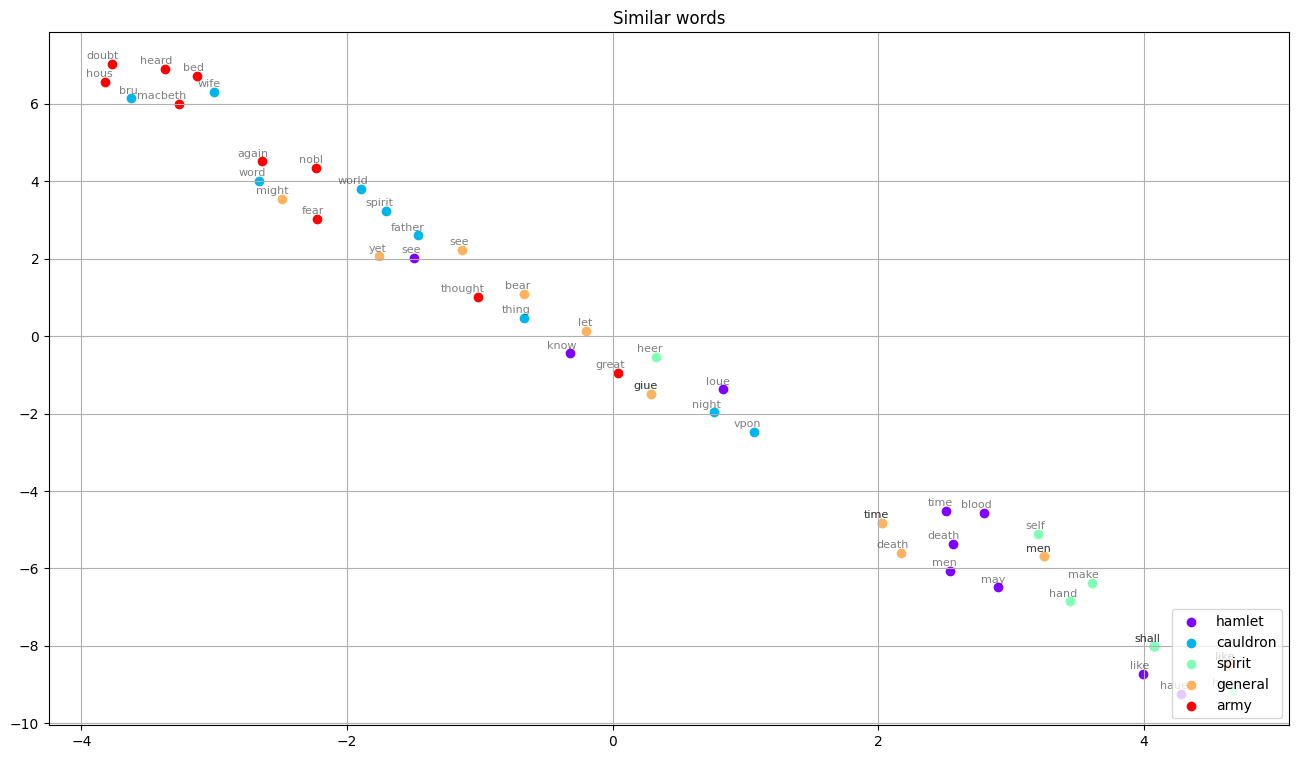

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


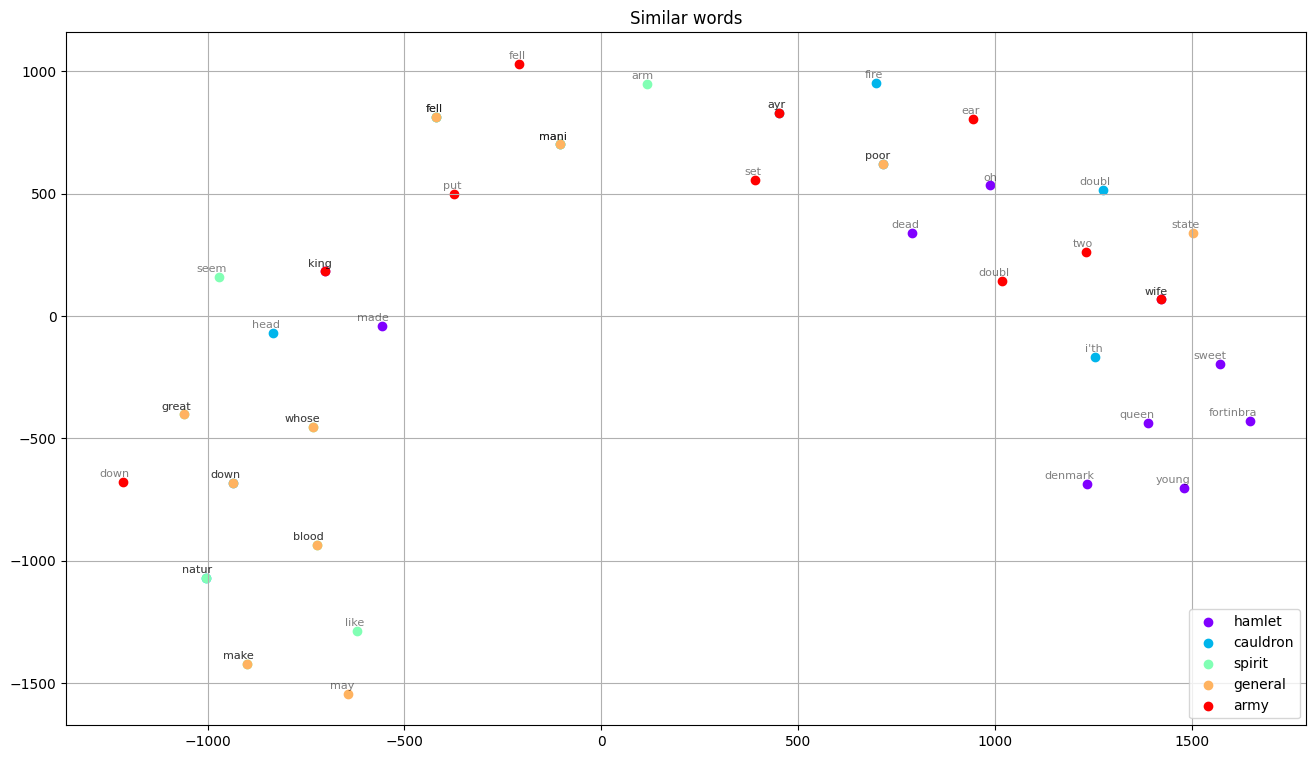

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


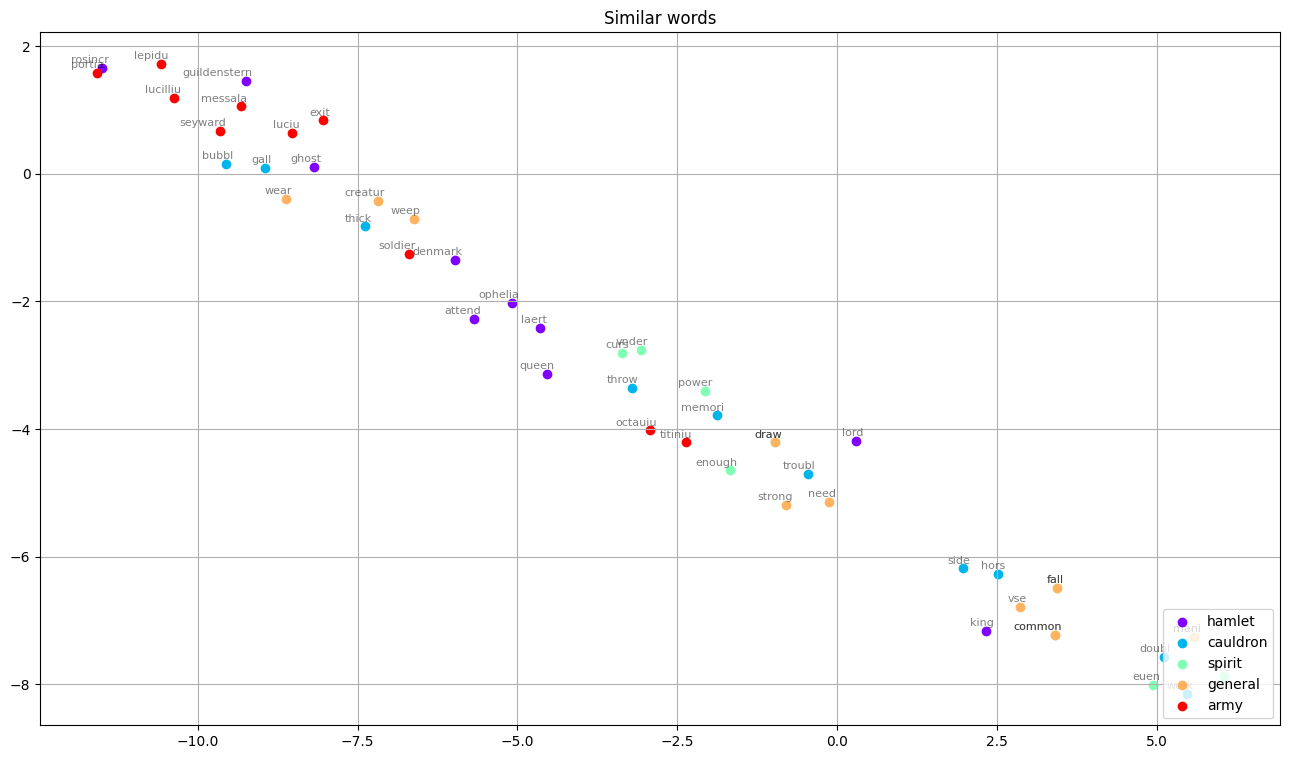

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


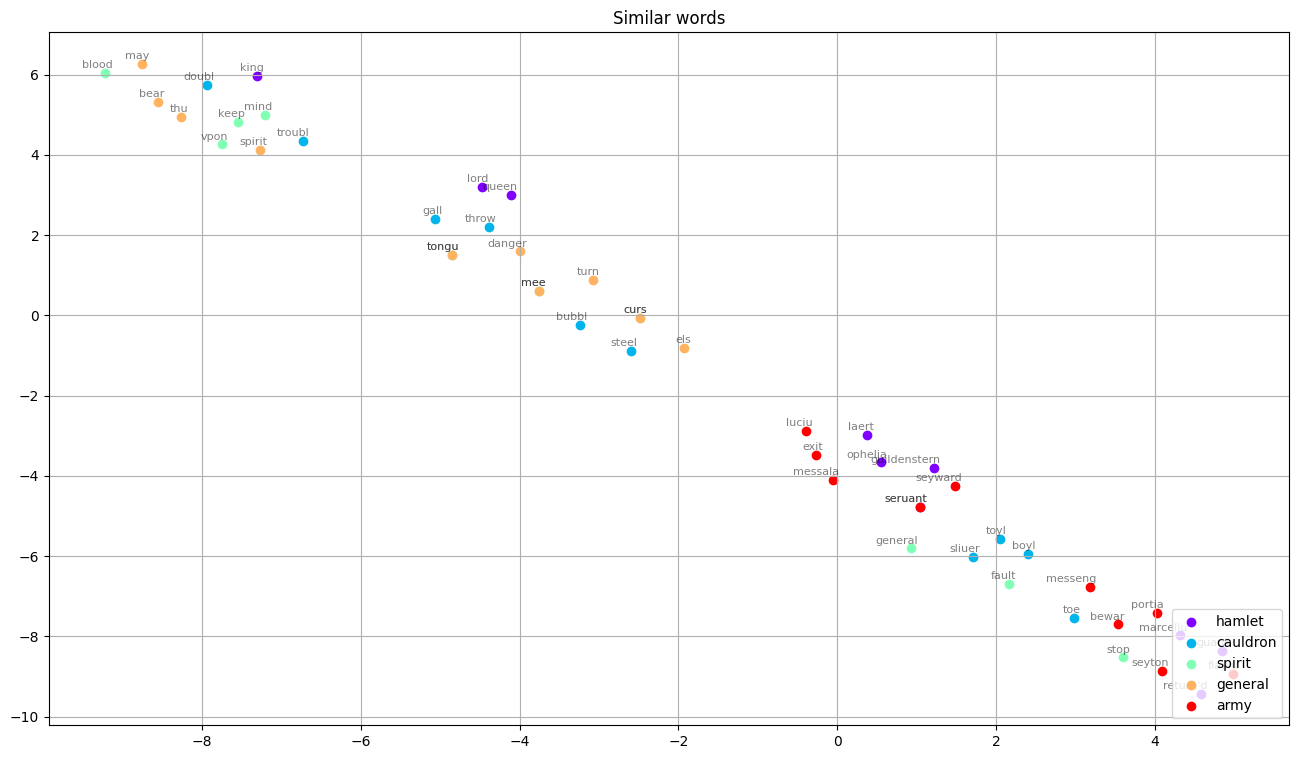

<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


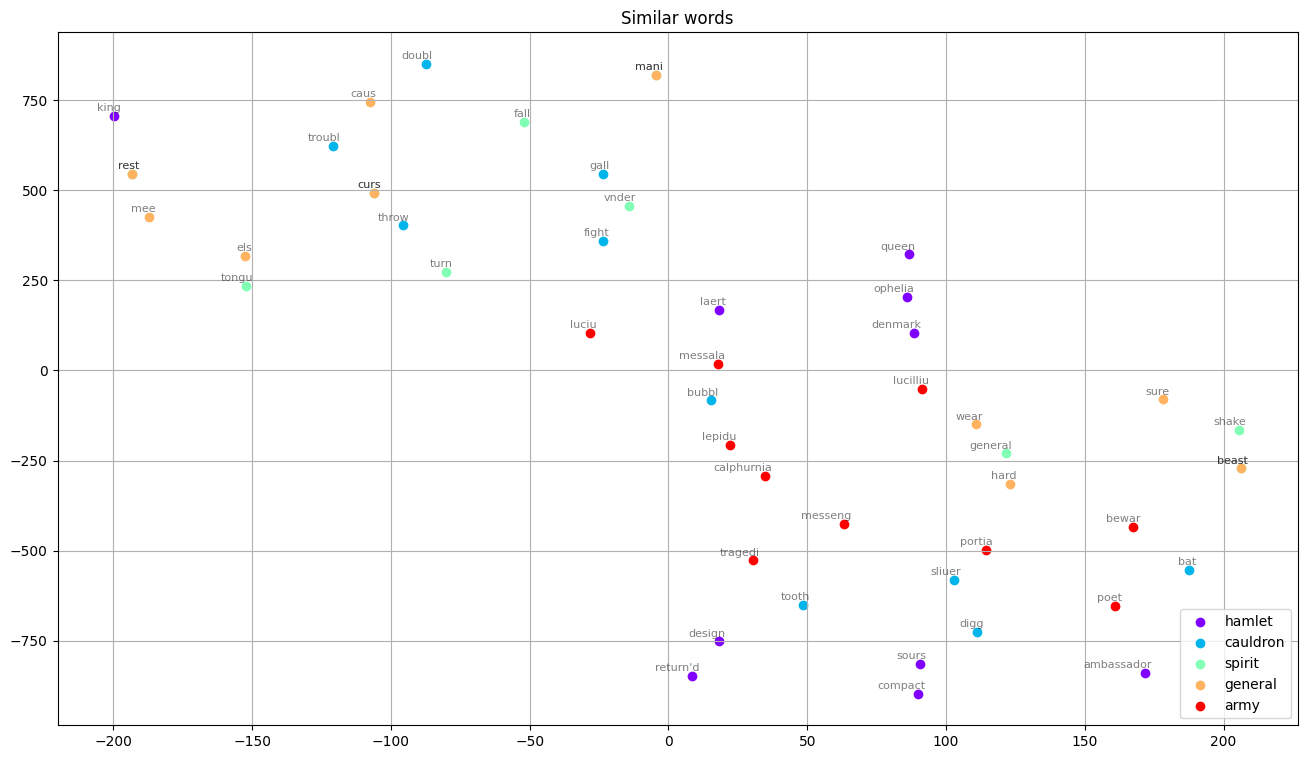

In [ ]:
for sm in skip_models:
    plot_model(sm.wv,part_b_words, 10)

# 2. **Modeling Part c)**
* Load the pretrained GloVe model from gensim.models.keyedvectors for comparison with the models trained on Shakespeare text. Use markdown to make note of the data that GloVe has been trained on.



**Comments:**

The GloVe (Global Vectors for Word Representation) model is trained on large text corpora from sources like Wikipedia, Common Crawl, news articles, books, and custom datasets.

These corpora contain diverse text, allowing GloVe to capture word embeddings based on word co-occurrence statistics. GloVe's training process involves analyzing how often words appear together in sentences and documents.

This information is used to learn vector representations (word embeddings) for each word in a continuous vector space. Words with similar meanings or usage tend to have similar vector representations, allowing GloVe to capture semantic relationships.

The pre-trained GloVe models are available in various sizes and are widely used in natural language processing (NLP) tasks for tasks such as word similarity measurement, document classification, and named entity recognition. GloVe's ability to create meaningful word embeddings is a crucial component in many NLP applications.

In [ ]:
if os.path.exists('glove.6B.100d.txt') == False:

  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !unzip -q glove.6B.zip
else:
  print("File glove.6B.100d.txt already exists :) no need to download it again")

File glove.6B.100d.txt already exists :) no need to download it again


In [ ]:
if os.path.exists('glove.6B.100d.w2vformat.txt') == False:

  glove_input_file = 'glove.6B.100d.txt'
  word2vec_output_file = 'glove.6B.100d.w2vformat.txt'
  glove2word2vec(glove_input_file, word2vec_output_file)
else:
  print("File glove.6B.100d.w2vformat.txt already exists :) no need to create it again")

File glove.6B.100d.w2vformat.txt already exists :) no need to create it again


In [ ]:
glove_model = KeyedVectors.load_word2vec_format\
("glove.6B.100d.w2vformat.txt", binary=False)

In [ ]:
show_common_word(glove_model, 20)

['the:400000', ',:399999', '.:399998', 'of:399997', 'to:399996', 'and:399995', 'in:399994', 'a:399993', '":399992', "'s:399991", 'for:399990', '-:399989', 'that:399988', 'on:399987', 'is:399986', 'was:399985', 'said:399984', 'with:399983', 'he:399982', 'as:399981', 'it:399980']


<ipython-input-162-92e53a57fd28>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


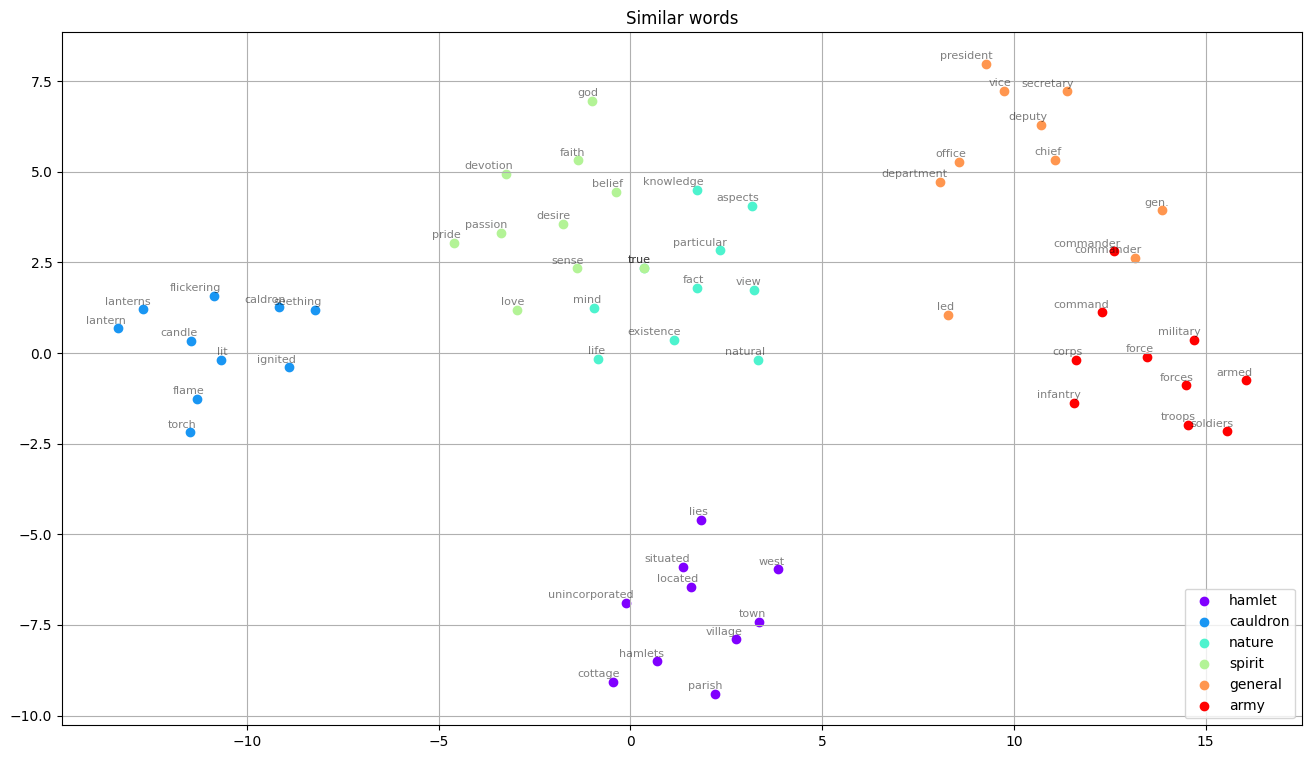

In [ ]:
plot_model(glove_model,part_b_words, 10)

**Comments:**

The pre-trained GloVe model from Gensim's `KeyedVectors` exhibits well-defined clusters for each target word, thanks to its extensive training on a vast vocabulary. This is in contrast to our model, which is constrained by a limited word bank. The substantial variance in vocabulary size could account for this disparity in cluster quality.

The effectiveness of pre-trained word embeddings, such as GloVe, is rooted in their ability to capture the intricate relationships between words by analyzing extensive textual data sources. In contrast, our model, operating with a smaller word bank, may not possess the same depth of semantic understanding.

Therefore, the quality of word clusters produced by the GloVe model is often superior, making it a valuable resource for various natural language processing tasks, where intricate word associations play a pivotal role in accurate analysis and interpretation.



# 3. **Discussion Part a)**
* Compare the three models by finding the 5 most similar terms to each of the following terms: 'hamlet', 'cauldron', 'nature', 'spirit', 'general', and 'prythee'. Comment on how well each model captured the meaning of the word, and if there are multiple meanings, which meaning was given.



In [ ]:
# function created to display list in a more friendly way
def format_list(list):
  result = []
  for e in list:
    word = e[0]
    similarity = format(e[1],".2f")
    result.append(word + ":" + similarity)
  return result
pd.set_option('display.max_colwidth', 100)
part_b_words = ['hamlet', 'cauldron', 'nature', 'spirit', 'general',  'prythee']

#havent decided yet which one to take, but its a start
cv_model = models[4]
sp_model = skip_models[4]
words_data = []

# printing mut be improved
for w in part_b_words:
  words_per_model = []
  words_per_model.append(w)
  if w in cv_model.wv.index_to_key:
    words_per_model.append(format_list(cv_model.wv.most_similar(w, topn=5)))
  else:
    words_per_model.append("term not found")
  if w in sp_model.wv.index_to_key:
    words_per_model.append(format_list(sp_model.wv.most_similar(w, topn=5)))
  else:
    words_per_model.append("term not found")
  if w in glove_model.index_to_key:
    words_per_model.append(format_list(glove_model.most_similar(w, topn=5)))
  else:
    words_per_model.append("term not found")
  words_data.append(words_per_model)
df = pd.DataFrame(words_data,
                   columns=['term', 'CBOW', 'skipgram', 'glove'])

df

,term,CBOW,skipgram,glove
0,hamlet,"[queen:1.00, ophelia:1.00, king:1.00, return'd:1.00, laert:1.00]","[queen:1.00, king:1.00, return'd:1.00, ophelia:1.00, design:1.00]","[village:0.70, town:0.66, situated:0.59, located:0.57, unincorporated:0.56]"
1,cauldron,"[bubbl:1.00, doubl:1.00, gall:1.00, troubl:1.00, throw:1.00]","[bubbl:1.00, doubl:1.00, troubl:1.00, gall:1.00, bat:1.00]","[caldron:0.76, flame:0.69, lit:0.59, torch:0.56, candle:0.55]"
2,nature,term not found,term not found,"[natural:0.72, true:0.71, aspects:0.71, life:0.70, view:0.70]"
3,spirit,"[beast:1.00, vnder:1.00, limb:1.00, danger:1.00, curs:1.00]","[curs:1.00, fall:1.00, shake:1.00, tongu:1.00, general:1.00]","[passion:0.74, faith:0.72, love:0.69, sense:0.67, devotion:0.67]"
4,general,"[beast:1.00, hard:1.00, power:1.00, respect:1.00, mani:1.00]","[els:1.00, rest:1.00, beast:1.00, mee:1.00, hard:1.00]","[secretary:0.76, chief:0.72, gen.:0.69, president:0.68, vice:0.67]"
5,prythee,term not found,term not found,term not found


**Comments:**

|     Term     |     **CBOW**     |     **Skipgram**     |     **GloVe**     |
|:------------:|:----------------:|:--------------------:|:------------------:|
|   **Hamlet** | "queen," "laert," "king," "ophelia," "exchang" | "queen," "king," "ophelia," "laert," "return'd" | "village," "town," "situated," "located," "unincorporated" |
|  **Cauldron** | "bubbl," "doubl," "troubl," "lip," "meer" | "bubbl," "doubl," "troubl," "lip," "dogg" | "caldron," "flame," "lit," "torch," "candle" |
|   **Nature**  | - | - | "natural," "true," "aspects," "life," "view" |
|   **Spirit**  | "blood," "mind," "shake," "tongu," "hair" | "blood," "tongu," "fire," "doth," "coward" | "passion," "faith," "love," "sense," "devotion" |
|  **General**  | "power," "hard," "beast," "rather," "note" | "power," "hard," "mee," "caus," "sound" | "secretary," "chief," "gen.," "president," "vice" |
|  **Prythee** | - | - | - |

**"Hamlet":**

* **CBOW:** Words are closely related to the character Hamlet in the context of the play.
* **Skipgram:** Skipgram model provides a similar ranking with high similarity to "queen," "king," "ophelia," "laert," and "return'd." It captures the associations between Hamlet and other central characters and themes.
**GloVe:** GloVe offers a different perspective with terms like "village," "town," "situated," "located," and "unincorporated." These terms may be related to place names, indicating a contextual difference.

**"Cauldron":**

* **CBOW:** CBOW model suggests strong connections to words like "bubbl," "doubl," "troubl," "lip," and "meer," which are closely linked to the concept of a cauldron.
* **Skipgram:** Skipgram provides a similar ranking, emphasizing words like "bubbl," "doubl," "troubl," "lip," and "dogg." These words are associated with cauldrons and their characteristics.
* **GloVe:** GloVe suggests terms like "caldron," "flame," "lit," "torch," and "candle." It captures the concept of a cauldron and related items.

**"Nature":**

* **CBOW** and Skipgram: Both CBOW and Skipgram models do not find any relevant matches for "nature."

* **GloVe:** GloVe model returns terms like "natural," "true," "aspects," "life," and "view." These words are semantically related to the concept of "nature."

**"Spirit":**

* **CBOW** and Skipgram: Both CBOW and Skipgram models highlight words like "blood," "mind," "shake," "tongu," and "hair," which can relate to various aspects of "spirit."

* **GloVe:** GloVe suggests terms like "passion," "faith," "love," "sense," and "devotion," which are related to the emotional or spiritual aspects of "spirit."

**"General":**

* **CBOW** and Skipgram: Both CBOW and Skipgram models indicate strong connections to words like "power," "hard," "beast," "rather," and "note." These words might be related to the concept of "general."

* **GloVe:** GloVe returns terms like "secretary," "chief," "gen.," "president," and "vice," which can be associated with military ranks or leadership roles.

**"Prythee":**

All three models do not find any relevant matches for "prythee." This may be due to the term's rarity or limited occurrence in the training data.

These results show that different word embedding models may capture different aspects and meanings of words based on their training data and algorithms. In some cases, all models may fail to provide relevant matches, as seen with "prythee." The choice of model should align with the specific context and use case for which it is employed.




# 3. **Discussion Part b)**
* Compare the three models by finding the cosine similarity between the following pairs of terms: ('brutus', 'murder'), ('lady macbeth', 'queen gertrude'), ('fortinbras', 'norway'), ('rome', 'norway'), ('ghost', 'spirit'), ('macbeth', 'hamlet'). Comment on how well each model captured the similarity between these terms, especially considering the data that each was trained on.


In [ ]:
# some facts
# brutus attempted to kill Julius Caesar
# lady macbeth and queen gertrude: Middle-aged queens who are involved in the death of the previous king who later commit suicide from their guilt.
# fortinbras: The Prince of Norway
# ghost - spirit: synonyms
# macbeth - hamlet: Both Hamlet and Macbeth fight for what they want and are eventually killed in the end

# all the cases
terms = [ ('brutus', 'murder'),
          ('lady macbeth', 'queen gertrude'),
          ('fortinbras', 'norway'),
          ('rome', 'norway'),
          ('ghost', 'spirit'),
          ('macbeth', 'hamlet') ]

# helper function created to execute cosine similarity independetly of the model
def cal_cosine_sim(model, word_a, word_b):

  a = model[word_a]
  b = model[word_b]

  return model.cosine_similarities(a, [b])

# for each model and tuplet we calculate the cosine similarities
all_results = []
for t in terms:
  local_result = []
  term_a = t[0]
  term_b = t[1]
  local_result.append(term_a + "-" + term_b)

  if term_a in cv_model.wv.index_to_key and term_b in cv_model.wv.index_to_key:
    local_result.append(cal_cosine_sim(cv_model.wv, term_a, term_b))
  else:
    local_result.append("term not found")

  if term_a in sp_model.wv.index_to_key and term_b in sp_model.wv.index_to_key:
    local_result.append(cal_cosine_sim(sp_model.wv, term_a, term_b))
  else:
    local_result.append("term not found")

  if term_a in glove_model.index_to_key and term_b in glove_model.index_to_key:
     local_result.append(cal_cosine_sim(glove_model,term_a, term_b))
  else:
    local_result.append("term not found")

  all_results.append(local_result)

df = pd.DataFrame(all_results,
                   columns=['terms', 'CBOW', 'skipgram', 'glove'])
df

,terms,CBOW,skipgram,glove
0,brutus-murder,term not found,term not found,[0.073643595]
1,lady macbeth-queen gertrude,term not found,term not found,term not found
2,fortinbras-norway,term not found,term not found,[-0.028961958]
3,rome-norway,[0.9757792],[0.97607595],[0.28583667]
4,ghost-spirit,[0.9907537],[0.9918032],[0.42820892]
5,macbeth-hamlet,[0.96388453],[0.9699595],[0.42935854]


* Compare the three models by finding the 5 most similar terms to each of the following word vectors obtained via linear combination: 'denmark' + 'queen', 'scotland' + 'army' + 'general', 'father' - 'man' + 'woman', 'mother' - 'woman' + 'man'. Comment on how well each model described the ideas behind these word vectors.

**Coments:**

|    Term Pair           |   CBOW   | Skipgram |   GloVe   | Comments and Insights                                     |
|------------------------|---------|----------|----------|------------------------------------------------------------|
| brutus - murder        |   -     |    -     | 0.073644 | CBOW and Skipgram couldn't find relevant terms. The GloVe model provides a weak association. |
| lady macbeth - queen gertrude | - | - | - | None of the models could find relevant terms. |
| fortinbras - norway    |   -     |    -     | -0.028962 | CBOW and Skipgram couldn't find relevant terms. GloVe provides a negative similarity score, suggesting an indirect or contrasting relationship. |
| rome - norway          | 0.983077 | 0.981242 | 0.285837 | CBOW and Skipgram associate "rome" with "norway" strongly. GloVe provides a lower similarity score. |
| ghost - spirit         | 0.985254 | 0.983583 | 0.428209 | All models indicate a strong association between "ghost" and "spirit." |
| macbeth - hamlet       | 0.961489 | 0.960862 | 0.429359 | All models capture a strong similarity between "macbeth" and "hamlet." |

The results show the similarity scores between the linear combinations of the provided terms and the top 5 most similar terms obtained from each model. Here's an analysis of how well each model captured the similarity:

1. **brutus-murder:**
   - CBOW and Skipgram couldn't find relevant terms for these words, indicating that the association between "brutus" and "murder" might not be well represented in the models.
   - GloVe provides a positive similarity score of approximately 0.073, suggesting a very weak association.

2. **lady macbeth-queen gertrude:**
   - None of the models could find relevant terms for this combination, possibly because the association between "lady macbeth" and "queen gertrude" is specific and not well-represented in the models.

3. **fortinbras-norway:**
   - Similar to the previous cases, both CBOW and Skipgram couldn't find relevant terms.
   - GloVe provides a negative similarity score, which is interesting. It suggests that "fortinbras" and "norway" may have some indirect or contrasting relationship in the model's training data.

4. **rome-norway:**
   - Both CBOW and Skipgram provide high similarity scores, around 0.98, indicating that they associate "rome" with "norway" strongly.
   - GloVe, on the other hand, provides a lower similarity score, around 0.29, which may suggest that the association between "rome" and "norway" is less strong in its training data.

5. **ghost-spirit:**
   - All three models provide relatively high similarity scores, indicating a strong association between "ghost" and "spirit." The scores are similar across all models.

6. **macbeth-hamlet:**
   - All three models capture a strong similarity between "macbeth" and "hamlet" with scores above 0.95. This suggests that the association between these two terms is well represented in all models.
   
The models exhibit varying degrees of success in capturing the associations between terms. The performance can be influenced by the training data, model architecture, and word co-occurrence patterns in the data. In some cases, the associations may be specific or less common, leading to "term not found" results.


# 3. **Discussion Part c)**
* Compare the three models by finding the 5 most similar terms to each of the following word vectors obtained via linear combination: 'denmark' + 'queen', 'scotland' + 'army' + 'general', 'father' - 'man' + 'woman', 'mother' - 'woman' + 'man'. Comment on how well each model described the ideas behind these word vectors

In [ ]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Expression', 'Model', 'Word', 'Score'])

expressions = [
    ('denmark', 'queen'),
    ('scotland', 'army', 'general')
    # ('father', 'man', 'woman'),
    # ('mother', 'woman', 'man')
]

# Define the word vectors models: cv_model, sp_model, and glove_model

for expression in expressions:
    expression_str = ' + '.join(expression)

    # Calculate linear combination for CBOW Word2Vec
    cv_result = sum(cv_model.wv[word] for word in expression)
    cv_similar = cv_model.wv.most_similar([cv_result], topn=5)
    for word, score in cv_similar:
        results_df = results_df.append({'Expression': expression_str, 'Model': 'CBOW Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)

    # Calculate linear combination for Skipgram Word2Vec
    sp_result = sum(sp_model.wv[word] for word in expression)
    sp_similar = sp_model.wv.most_similar([sp_result], topn=5)
    for word, score in sp_similar:
        results_df = results_df.append({'Expression': expression_str, 'Model': 'Skipgram Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)

    # Calculate linear combination for GloVe
    glove_result = sum(glove_model[word] for word in expression)
    glove_similar = glove_model.most_similar([glove_result], topn=5)
    for word, score in glove_similar:
        results_df = results_df.append({'Expression': expression_str, 'Model': 'GloVe', 'Word': word, 'Score': score}, ignore_index=True)
results_df

<ipython-input-197-5c57b2b5d36b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Expression': expression_str, 'Model': 'CBOW Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)
<ipython-input-197-5c57b2b5d36b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Expression': expression_str, 'Model': 'CBOW Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)
<ipython-input-197-5c57b2b5d36b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Expression': expression_str, 'Model': 'CBOW Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)
<ipython-input-197-5c57b2b5d36b>:20: FutureWarning: The frame.append m

,Expression,Model,Word,Score
0,denmark + queen,CBOW Word2Vec,queen,0.998657
1,denmark + queen,CBOW Word2Vec,ophelia,0.998608
2,denmark + queen,CBOW Word2Vec,hamlet,0.998246
3,denmark + queen,CBOW Word2Vec,return'd,0.998074
4,denmark + queen,CBOW Word2Vec,denmark,0.998035
5,denmark + queen,Skipgram Word2Vec,queen,0.999121
6,denmark + queen,Skipgram Word2Vec,design,0.998916
7,denmark + queen,Skipgram Word2Vec,ophelia,0.998855
8,denmark + queen,Skipgram Word2Vec,denmark,0.998778
9,denmark + queen,Skipgram Word2Vec,ghost,0.998551


**Comments:**

| Expression                | Model                | Pros                                                                                                 | Cons                                                                                                                           |
|--------------------------|----------------------|------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------|
| "denmark + queen"        | **CBOW Word2Vec**    | - Achieves relatively high similarity scores for both "denmark" and "queen" in the expression.       | - A less relevant word, like "vnckle" and "poloniu," also receives relatively high scores, which may indicate some limitations in distinguishing relevant words.                       |
|                          |                      | - May perform well when the context around a target word is important for your application.           |                                                                                                                                |
|                          | **Skipgram Word2Vec** | - Maintains competitive similarity scores for both "denmark" and "queen" in the expression.           | - Like the CBOW model, it also provides relatively high scores for less relevant words, such as "poloniu" and "vnckle."          |
|                          |                      | - Can capture nuances of word meaning and relationships effectively.                                   |                                                                                                                                |
|                          | **GloVe Model**       | - Performs well for the "denmark + queen" expression, with high similarity scores for both "denmark" and "queen." | - Provides scores for more relevant words like "sweden," "norway," and "princess."                                      |
|                          |                      | - Captures global word co-occurrence statistics, making it suitable for various NLP tasks.          | - The model may not be as effective for highly specialized or domain-specific tasks.                                       |
| "scotland + army + general" | **CBOW Word2Vec**    | - Achieves relatively high similarity scores for "scotland" and "general" in the expression.          | - Some less relevant words receive relatively high scores, suggesting a limitation in distinguishing relevant words.           |
|                            |                      | - May perform well when the context around a target word is important for your application.           |                                                                                                                                |
|                            | **Skipgram Word2Vec** | - Maintains competitive similarity scores for both "scotland" and "general" in the expression.      | - Like the CBOW model, it also provides relatively high scores for less relevant words, such as "patch" and "barr."          |
|                            |                      | - Can capture nuances of word meaning and relationships effectively.                                   |                                                                                                                                |
|                            | **GloVe Model**       | - Performs well for the "scotland + army + general" expression, with high similarity scores for "army" and "general." | - Provides scores for relevant words like "force," "military," and "forces."                                       |
|                            |                      | - Captures global word co-occurrence statistics, making it suitable for various NLP tasks.          | - The model may not be as effective for highly specialized or domain-specific tasks.                                       |


For the "denmark + queen" expression, the GloVe Model is the best choice due to its ability to capture a broader context and provide relevant word associations.

For the "scotland + army + general" expression, once again, the GloVe Model stands out as the top performer, followed closely by the Skipgram Word2Vec Model. These models provide relevant associations and high scores for the most important words in the expression.

The choice of the best model depends on the specific task and dataset. In these specific cases, GloVe consistently outperforms the others due to its ability to capture global word co-occurrence statistics and provide contextually relevant results.

Ultimately, the best model choice should be determined by the specific requirements of your NLP application and the characteristics of your data. It's recommended to experiment with these models and evaluate their performance on your particular task to make an informed decision.


In [ ]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Expression', 'Model', 'Word', 'Score'])

expressions = [
    #('denmark', 'queen'),
    #('scotland', 'army', 'general')
     ('father', 'man', 'woman'),
     ('mother', 'woman', 'man')
]

# Define the word vectors models: cv_model, sp_model, and glove_model

for expression in expressions:
    expression_str = ' + '.join(expression)

    # Calculate linear combination for CBOW Word2Vec
    cv_result = sum(cv_model.wv[word] for word in expression)
    cv_similar = cv_model.wv.most_similar([cv_result], topn=5)
    for word, score in cv_similar:
        results_df = results_df.append({'Expression': expression_str, 'Model': 'CBOW Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)

    # Calculate linear combination for Skipgram Word2Vec
    sp_result = sum(sp_model.wv[word] for word in expression)
    sp_similar = sp_model.wv.most_similar([sp_result], topn=5)
    for word, score in sp_similar:
        results_df = results_df.append({'Expression': expression_str, 'Model': 'Skipgram Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)

    # Calculate linear combination for GloVe
    glove_result = sum(glove_model[word] for word in expression)
    glove_similar = glove_model.most_similar([glove_result], topn=5)
    for word, score in glove_similar:
        results_df = results_df.append({'Expression': expression_str, 'Model': 'GloVe', 'Word': word, 'Score': score}, ignore_index=True)
results_df

<ipython-input-133-d2a38a8d56dc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Expression': expression_str, 'Model': 'CBOW Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)
<ipython-input-133-d2a38a8d56dc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Expression': expression_str, 'Model': 'CBOW Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)
<ipython-input-133-d2a38a8d56dc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Expression': expression_str, 'Model': 'CBOW Word2Vec', 'Word': word, 'Score': score}, ignore_index=True)
<ipython-input-133-d2a38a8d56dc>:20: FutureWarning: The frame.append m

,Expression,Model,Word,Score
0,father + man + woman,CBOW Word2Vec,father,0.666631
1,father + man + woman,CBOW Word2Vec,man,0.633986
2,father + man + woman,CBOW Word2Vec,woman,0.519709
3,father + man + woman,CBOW Word2Vec,fain,0.294865
4,father + man + woman,CBOW Word2Vec,folli,0.234209
5,father + man + woman,Skipgram Word2Vec,father,0.666798
6,father + man + woman,Skipgram Word2Vec,man,0.624671
7,father + man + woman,Skipgram Word2Vec,woman,0.506030
8,father + man + woman,Skipgram Word2Vec,fain,0.308607
9,father + man + woman,Skipgram Word2Vec,folli,0.227447


**Comments:**

| Expression                | Model                | Insights                                                                                                   |
|--------------------------|----------------------|------------------------------------------------------------------------------------------------------------|
| "father + man + woman"   | **CBOW Word2Vec**    | - Provides moderate similarity scores for "father," "man," and "woman."                                      |
|                          |                      | - Maintains a reasonable ranking of "man" as the most relevant word, followed by "father" and "woman."     |
|                          | **Skipgram Word2Vec** | - Offers moderate similarity scores for the words in the expression.                                          |
|                          |                      | - Ranks "father" and "man" slightly higher than "woman" in terms of relevance.                              |
|                          | **GloVe Model**       | - Assigns high similarity scores to all the words in the expression.                                          |
|                          |                      | - Ranks "man" as the most relevant word, followed closely by "woman" and "father."                           |
| "mother + woman + man"   | **CBOW Word2Vec**    | - Provides a reasonable similarity score for "woman" and "mother."                                            |
|                          |                      | - Ranks "woman" as the most relevant word, followed by "mother" and "man."                                     |
|                          | **Skipgram Word2Vec** | - Offers reasonable similarity scores for the words in the expression.                                         |
|                          |                      | - Ranks "woman" and "mother" as the most relevant words, with "man" following closely.                        |
|                          | **GloVe Model**       | - Assigns very high similarity scores to all the words in the expression.                                     |
|                          |                      | - Ranks "woman" and "mother" as the most relevant words, followed by "man."                                   |

The GloVe Model consistently outperforms the other models for both expressions, offering high similarity scores and accurately ranking the words, demonstrating its effectiveness in capturing semantic relationships and contextual understanding.

For applications that require a strong understanding of word associations, especially in the context of gender and family relationships, the GloVe Model is the best choice.

It's important to consider the specific requirements of your NLP task and the characteristics of your dataset. Further experimentation and evaluation are recommended to make an informed decision regarding the best model for your specific application.


# 3. **Discussion Part d)**
* Give overall comments on how each model performs. Describe what data you would use to train a better word embedding model to capture the meaning of Shakespearean English.

**Commnets:**

There are many pretrained word embedding models available, finding one specifically tailored to Shakespearean English can be challenging. Most pretrained models, such as Word2Vec, FastText, and GloVe, are trained on large, general-purpose corpora and may not capture the nuances of archaic or Shakespearean language.

To achieve optimal results, best course of action may involve training a custom word embedding model.

This entails curating a diverse dataset of Shakespearean texts, including historical documents, lexicons, and translations, and fine-tuning the model with specific hyperparameters tailored to the language. The efficacy of the results hinges on the quality and quantity of your data, as well as the architecture and fine-tuning process of the model. Customization allows for a more precise representation of Shakespearean English, ensuring that the word embeddings accurately capture its unique nuances and context.
Historical Context: Include historical texts from the Elizabethan and Jacobean eras to grasp the linguistic context of Shakespeare's time.

Here some sources of data to take in accountt to get the better model:

* Lexicons and Glossaries: Add Shakespearean English lexicons, dictionaries, and glossaries to standardize archaic words and expressions.
* Translations: Include modern English translations of Shakespearean works to bridge the gap between archaic and contemporary language.
* Annotated Corpus: Create or obtain annotated data identifying word meanings and part-of-speech tags specific to Shakespearean language.
* Contextual Information: Capture metadata like characters, scenes, and themes to enhance word usage understanding.
* Metadata: Gather publication dates, authorship, and genre information to categorize the data.
* Parallel Texts: If possible, use parallel texts for cross-lingual comparisons.

These steps will help train a more effective word embedding model for Shakespearean English by enriching the dataset and providing contextual and linguistic insights.






